<a href="https://colab.research.google.com/github/elpeme/Dialogflow-Policy-enforcer/blob/main/Pedro_Melendez_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [3]:
def Q1(num_examples=5):
  # Examining data 
  for i in range(num_examples):   
    print("Item {} label name/topic: {}".format(i+1, newsgroups_train.target_names[test_labels[i]]))
    print("Item {} data: {}\n".format(i+1, test_data[i]))

Q1(5)


Item 1 label name/topic: talk.religion.misc
Item 1 data: 
Just taking a guess, perhaps it was that Koresh had peaceably been served
with warrants before, and he did not shoot anyone but instead went with the
police without fighting.
--
"On the first day after Christmas my truelove served to me...  Leftover Turkey!
On the second day after Christmas my truelove served to me...  Turkey Casserole
    that she made from Leftover Turkey.
[days 3-4 deleted] ...  Flaming Turkey Wings! ...
   -- Pizza Hut commercial (and M*tlu/A*gic bait)

Item 2 label name/topic: sci.space
Item 2 data: Hello out there,
If your familiar with the COMET program then this concerns you.
COMET is scheduled to be launched from Wallops Island sometime in June.
Does anyone know if an official launch date has been set?

Item 3 label name/topic: comp.graphics
Item 3 data: 
Playmation is available direct from Anjon & Associates for $299.  It's hard
to beat that price.  Also, you'd be better off with a newer version than
a

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [4]:
def Q2():
  # Transform the training data into a matrix of word unigram feature vectors
  vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(train_data)
  print("1. Size of word unigram feature vector vocabulary: {}".format(len(vectorizer.get_feature_names_out())))
  print("The average number of non-zero features per example is: {:.4f}".format(X.nnz/X.shape[0]))
  print("The fraction of the non-zero entries in the matrix: {:.4f}".format(X.nnz/(X.shape[0] * X.shape[1])))
  print("The 0th feature string is: \"{}\"".format(vectorizer.get_feature_names_out()[0]))
  print("The last feature string is: \"{}\"".format(vectorizer.get_feature_names_out()[-1:][0]))


  # Transform training data into a matrix of word unigram feature vectors restricting to ["atheism", "graphics", "space", "religion"]
  vocabulary=["atheism", "graphics", "space", "religion"]
  vectorizer = CountVectorizer(vocabulary=vocabulary)
  X = vectorizer.fit_transform(train_data)
  print("\n2. Vector matrix with vocabulary: ",  end = '')
  print(*vocabulary, sep = ", ")
  print("Size of vocabulary: {}".format(len(vectorizer.get_feature_names_out())))
  print("The average number of non-zero features per example is: {:.4f}".format(X.nnz/X.shape[0]))
  print("The fraction of the non-zero entries in the matrix: {:.4f}".format(X.nnz/(X.shape[0] * X.shape[1])))

  # Transform the training data into a matrix of character bigram and trigram feature vectors: ngram_range=(2,3)
  vectorizer = CountVectorizer(analyzer='char',ngram_range=(2,3))
  X = vectorizer.fit_transform(train_data)
  print("\n3. Matrix of character bigram and trigram feature vectors: ")
  print("Size of vocabulary: {}".format(len(vectorizer.get_feature_names_out())))
  print("The average number of non-zero features per example is: {:.4f}".format(X.nnz/X.shape[0]))
  print("The fraction of the non-zero entries in the matrix: {:.4f}".format(X.nnz/(X.shape[0] * X.shape[1])))


  # Transform the training data into a matrix of word unigram feature vectors and prune words that appear in fewer than 10 documents
  vectorizer = CountVectorizer(min_df=10)
  X = vectorizer.fit_transform(train_data)
  print("\n4. Matrix of word unigram feature vectors and pruned words that appear in fewer than 10 documents: ")
  print("Size of vocabulary: {}".format(len(vectorizer.get_feature_names_out())))
  print("The average number of non-zero features per example is: {:.4f}".format(X.nnz/X.shape[0]))
  print("The fraction of the non-zero entries in the matrix: {:.4f}".format(X.nnz/(X.shape[0] * X.shape[1])))


  # Transform the training data into a matrix of word unigram feature vectors
  vectorizer = CountVectorizer()
  dev_vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(train_data)
  dev_vectorizer = CountVectorizer()
  dev_vector_fit = dev_vectorizer.fit_transform(dev_data)  
  words_missing_in_training = list(set(dev_vectorizer.get_feature_names_out()) - set(vectorizer.get_feature_names_out()))
  print("\n5. Count of words in the development vocabulary missing in training dataset: {}".format(len(words_missing_in_training)))
  print("Fraction of words in the development vocabulary that are missing from the training vocabulary {}".format(len(words_missing_in_training)/len(dev_vectorizer.get_feature_names_out())))

Q2()


1. Size of word unigram feature vector vocabulary: 26879
The average number of non-zero features per example is: 96.7060
The fraction of the non-zero entries in the matrix: 0.0036
The 0th feature string is: "00"
The last feature string is: "zyxel"

2. Vector matrix with vocabulary: atheism, graphics, space, religion
Size of vocabulary: 4
The average number of non-zero features per example is: 0.2684
The fraction of the non-zero entries in the matrix: 0.0671

3. Matrix of character bigram and trigram feature vectors: 
Size of vocabulary: 35478
The average number of non-zero features per example is: 684.1917
The fraction of the non-zero entries in the matrix: 0.0193

4. Matrix of word unigram feature vectors and pruned words that appear in fewer than 10 documents: 
Size of vocabulary: 3064
The average number of non-zero features per example is: 72.6760
The fraction of the non-zero entries in the matrix: 0.0237

5. Count of words in the development vocabulary missing in training dataset: 

### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def Q3():
  
  vectorizer = CountVectorizer()
  X_train_vect = vectorizer.fit_transform(train_data)
  dev_vect = vectorizer.transform(dev_data)

  # Kneighbor models with different k value
  for k in [1, 3, 5, 7, 9]:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_vect, train_labels)
    train_predicted_labels = model.predict(dev_vect)
    print("\nk-Nearest Neigbor model with K = {}".format(k))
    print(" Model accuracy = %3.3f" %(metrics.accuracy_score(dev_labels, train_predicted_labels)))
    print(" F1 score: {:.6f}".format(metrics.f1_score(dev_labels, train_predicted_labels, average="weighted")))

  # Naive Bayes multinomial model with multiple Alphas
  multinomial_model = MultinomialNB()
  alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
  
  for alpha in alphas:
    # Create Bernulli model with each alpha value
    multinomial_model = MultinomialNB(alpha=alpha)

    # Train model
    multinomial_model.fit(X_train_vect, train_labels)

    # Get predicted labels
    multinomial_model_predicted_labels = multinomial_model.predict(dev_vect)

    print("\nNaive Bayes models with Alpha = {:.4f}".format(alpha))
    print(" multinomial Model accuracy: {:.6f}".format(multinomial_model.score(dev_vect, dev_labels))) 
    print(" F1 score: {:.6f}".format(metrics.f1_score(dev_labels, multinomial_model_predicted_labels, average="weighted")))

  # Logistic Regression model
  L2_regularization = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 100.0, 10000.0]

  for c in L2_regularization:
    logreg_model = LogisticRegression(C=c, solver="liblinear", multi_class="auto")
    logreg_model.fit(X_train_vect, train_labels)
    logreg_model_predicted_labels = logreg_model.predict(dev_vect)
    print("\nL2_regularization (C) = {:.4f}".format(c))
    print(" Logreg Model accuracy: {:.6f}".format(logreg_model.score(dev_vect, dev_labels))) 
    print(" F1 score: {:.6f}".format(metrics.f1_score(dev_labels, logreg_model_predicted_labels, average="weighted")))
    print(" Sum of squared weights of all topics: {:.4f}".format(np.sum(np.square(logreg_model.coef_))))
    for topic in logreg_model.coef_:
      print("  Sum of squared weighs by topic: {:.4f}".format(np.sum(np.square(topic))))

Q3()




k-Nearest Neigbor model with K = 1
 Model accuracy = 0.383
 F1 score: 0.380503

k-Nearest Neigbor model with K = 3
 Model accuracy = 0.414
 F1 score: 0.408415

k-Nearest Neigbor model with K = 5
 Model accuracy = 0.423
 F1 score: 0.428761

k-Nearest Neigbor model with K = 7
 Model accuracy = 0.444
 F1 score: 0.450479

k-Nearest Neigbor model with K = 9
 Model accuracy = 0.430
 F1 score: 0.436567

Naive Bayes models with Alpha = 0.0001
 multinomial Model accuracy: 0.769231
 F1 score: 0.762835

Naive Bayes models with Alpha = 0.0010
 multinomial Model accuracy: 0.775148
 F1 score: 0.770252

Naive Bayes models with Alpha = 0.0100
 multinomial Model accuracy: 0.779586
 F1 score: 0.775166

Naive Bayes models with Alpha = 0.1000
 multinomial Model accuracy: 0.792899
 F1 score: 0.790305

Naive Bayes models with Alpha = 0.5000
 multinomial Model accuracy: 0.788462
 F1 score: 0.786286

Naive Bayes models with Alpha = 1.0000
 multinomial Model accuracy: 0.781065
 F1 score: 0.777732

Naive Bayes

ANSWER: 
Why doesn't k-Nearest Neighbors work well for this problem?
I think it is because the data is too spread out, and with most values being zero, neighbors do not necessarily share similar features; therefore, k-nearest cannot accurately identify neighbors. 

Why doesn't Logistic regression work as well as Naive Bayes does?
I believe Naive Bayes works better because we have multiple classes in the dataset, the data appears to be conditionally independent, which is a requirement/assumption for Naive Bayes, and the data does not seem to be linear enough for logistic regression.


What is the relationship between logistic regression's sum of squared weights vs. C value? When C increases, the model coefficients increase too and vice versa; this is part of the regularization penalty that can help select features.





### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [6]:
def Q4():
  vectorizer = CountVectorizer(ngram_range=(2,2))

  X_train_vect = vectorizer.fit_transform(train_data)
  dev_vect = vectorizer.transform(dev_data)
  # Logistic Regression model

  logreg_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
  logreg_model.fit(X_train_vect, train_labels)

  print("\nLogistic regression with word bigram feature vectors and C = 0.5")
  print(" Table of features with largest weights by topic")

  top_20_features = []
  for topic in logreg_model.coef_:
    top_20_features.extend(np.argsort(topic)[-5:])

  feature_weight_topic_df = pd.DataFrame()

  feature_weight_topic_df["Feature"] = vectorizer.get_feature_names_out()[top_20_features]


  for i, topic in enumerate(logreg_model.coef_):
    feature_weight_topic_df[str(i)] = topic[top_20_features]
  print(feature_weight_topic_df.head(20))

Q4()


Logistic regression with word bigram feature vectors and C = 0.5
 Table of features with largest weights by topic
          Feature         0         1         2         3
0         are you  0.446953 -0.248257 -0.097135 -0.305625
1         you are  0.472740 -0.279894 -0.481305  0.028373
2        was just  0.482050 -0.131418 -0.128882 -0.227469
3     cheers kent  0.555720 -0.697918 -0.663766  0.534808
4      claim that  0.605549 -0.199067 -0.274345 -0.140364
5        is there -0.340882  0.754998 -0.468249 -0.257079
6       out there -0.274803  0.758658 -0.479057 -0.277089
7   comp graphics -0.292166  0.801208 -0.370885 -0.285186
8      in advance -0.459351  0.832567 -0.438501 -0.418453
9     looking for -0.630341  1.108375 -0.500050 -0.571869
10         it was -0.203029 -0.309687  0.525362 -0.313552
11       and such -0.204269 -0.337509  0.590524 -0.218202
12      sci space -0.258008 -0.329172  0.621087 -0.221245
13       the moon -0.350563 -0.492747  0.831085 -0.213800
14      the spa

ANSWER: 
Most of the high weights for each topic are negative in all the other topics; for example, "looking for" that has a weight of 1.108375 for topic 1 has a strong negative weight in all the other topics.

I don't think "Cheers kent" is a common phrase, yet it came up with a large weight in two different topics.

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [7]:
def no_preprocess(text):
    return text

def custom_preprocess(text):
    text = strip_accents_unicode(text)
    text = text.lower() 

    # I got the stop_words list from nltk.corpus.stopwords.words('english') 
    # but to avoid  using nltk.download('stopwords') I hardcoded it in the code.
    # stop_words = nltk.corpus.stopwords.words('english')
    stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
                  'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 
                  'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 
                  "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 
                  'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 
                  'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 
                  'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 
                  'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 
                  'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 
                  'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 
                  'into', 'through', 'during', 'before', 'after', 'above', 'below', 
                  'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 
                  'under', 'again', 'further', 'then', 'once', 'here', 'there', 
                  'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 
                  'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 
                  'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',
                  't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 
                  'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 
                  "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', 
                  "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 
                  'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 
                  'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
                  'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', 
                  "wouldn't"]
    
    # Removes stop words and applies stem using "ps.stem(word)"
    ps = nltk.stem.PorterStemmer()
    transformed_text = " ".join([ps.stem(word) for word in text.split() if ps.stem(word) not in stop_words])

    # Removes aphostropies 
    transformed_text = re.sub(r"[']"," ", transformed_text) 

    return transformed_text


def Q5():


  # Default preprocess
  vectorizer = CountVectorizer() 
  X_train_vect = vectorizer.fit_transform(train_data)
  dev_vect = vectorizer.transform(dev_data)

  logreg_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
  logreg_model.fit(X_train_vect, train_labels)
  logreg_model_predicted_labels = logreg_model.predict(dev_vect)
  print(" Default pre-processing Logreg Model \n Accuracy: {:.6f}".format(logreg_model.score(dev_vect, dev_labels))) 
  print(" F1 score: {:.6f}".format(metrics.f1_score(dev_labels, logreg_model_predicted_labels, average="weighted")))
  print(" Size of word unigram feature vector vocabulary: {}".format(len(vectorizer.get_feature_names_out())))
  
  # Vectorizer without preprocessing, just passing text as it was
  vectorizer = CountVectorizer(preprocessor=no_preprocess)
  X_train_vect = vectorizer.fit_transform(train_data)
  dev_vect = vectorizer.transform(dev_data)

  logreg_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
  logreg_model.fit(X_train_vect, train_labels)
  logreg_model_predicted_labels = logreg_model.predict(dev_vect)
  print(" No preprocessing Logreg Model \n Accuracy: {:.6f}".format(logreg_model.score(dev_vect, dev_labels))) 
  print(" F1 score: {:.6f}".format(metrics.f1_score(dev_labels, logreg_model_predicted_labels, average="weighted")))
  print(" Size of word unigram feature vector vocabulary: {}".format(len(vectorizer.get_feature_names_out())))


  # Vectorizer using the custom preprocessing function
  vectorizer = CountVectorizer(preprocessor=custom_preprocess)

  X_train_vect = vectorizer.fit_transform(train_data)
  dev_vect = vectorizer.transform(dev_data)


  logreg_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
  logreg_model.fit(X_train_vect, train_labels)
  logreg_model_predicted_labels = logreg_model.predict(dev_vect)
  print(" Custom preprocess Logreg Model \n Accuracy: {:.6f}".format(logreg_model.score(dev_vect, dev_labels))) 
  print(" F1 score: {:.6f}".format(metrics.f1_score(dev_labels, logreg_model_predicted_labels, average="weighted")))
  print(" Size of word unigram feature vector vocabulary: {}".format(len(vectorizer.get_feature_names_out())))


Q5()



 Default pre-processing Logreg Model 
 Accuracy: 0.714497
 F1 score: 0.708474
 Size of word unigram feature vector vocabulary: 26879
 No preprocessing Logreg Model 
 Accuracy: 0.711538
 F1 score: 0.706911
 Size of word unigram feature vector vocabulary: 33291
 Custom preprocess Logreg Model 
 Accuracy: 0.715976
 F1 score: 0.710246
 Size of word unigram feature vector vocabulary: 25051


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)



Models with L1 regularization strength C=0.01
 Vocabulary size: 17
 Default pre-processing Logreg Model with L2 regularization and vocabulary
 Accuracy: 0.483728
 F1 score: 0.468453


Models with L1 regularization strength C=0.05
 Vocabulary size: 125
 Default pre-processing Logreg Model with L2 regularization and vocabulary
 Accuracy: 0.646450
 F1 score: 0.639867


Models with L1 regularization strength C=0.1
 Vocabulary size: 211
 Default pre-processing Logreg Model with L2 regularization and vocabulary
 Accuracy: 0.692308
 F1 score: 0.687819


Models with L1 regularization strength C=0.2
 Vocabulary size: 383
 Default pre-processing Logreg Model with L2 regularization and vocabulary
 Accuracy: 0.677515
 F1 score: 0.670032


Models with L1 regularization strength C=0.5
 Vocabulary size: 752
 Default pre-processing Logreg Model with L2 regularization and vocabulary
 Accuracy: 0.662722
 F1 score: 0.657863


Models with L1 regularization strength C=1
 Vocabulary size: 1125
 Default pr

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


 Vocabulary size: 1820
 Default pre-processing Logreg Model with L2 regularization and vocabulary
 Accuracy: 0.678994
 F1 score: 0.674458


Models with L1 regularization strength C=10
 Vocabulary size: 3322
 Default pre-processing Logreg Model with L2 regularization and vocabulary
 Accuracy: 0.689349
 F1 score: 0.684172


Models with L1 regularization strength C=100
 Vocabulary size: 7825
 Default pre-processing Logreg Model with L2 regularization and vocabulary
 Accuracy: 0.692308
 F1 score: 0.686503


Models with L1 regularization strength C=1000
 Vocabulary size: 25371
 Default pre-processing Logreg Model with L2 regularization and vocabulary
 Accuracy: 0.696746
 F1 score: 0.691011


Models with L1 regularization strength C=100000
 Vocabulary size: 26877
 Default pre-processing Logreg Model with L2 regularization and vocabulary
 Accuracy: 0.715976
 F1 score: 0.709430


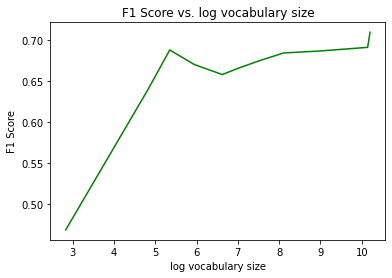

In [8]:
def Q6():
  # Keep this random seed here to make comparison easier.
  np.random.seed(0)

  f1_scores = []
  vocabulary_sizes = []


  # L1 regularization logreg model --> penalty="l1" with multiple C values
  C_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 10, 100, 1000, 100000]
  for C in C_values:    
      print("\n\nModels with L1 regularization strength C={}".format(C))
      
      vectorizer = CountVectorizer()
      X_train_vect = vectorizer.fit_transform(train_data)    
      dev_vect = vectorizer.transform(dev_data)

      logreg_model = LogisticRegression(C=C, solver="liblinear", penalty="l1", tol=.015, multi_class="auto")
      logreg_model.fit(X_train_vect, train_labels)
      logreg_model_predicted_labels = logreg_model.predict(dev_vect)

      # Get a list of non_zero features
      non_zero_features_index = []
      for topic in logreg_model.coef_:
        non_zero_features_index.extend(np.nonzero(topic)[0])

      # Remove duplicates from other topics
      non_zero_features_index = np.unique(non_zero_features_index)

      # Build vocabulary with words that have non-zero weight
      non_zero_features_vocab = []
      non_zero_features_vocab = vectorizer.get_feature_names_out()[non_zero_features_index]

      # Vectorizer with non-zero feature vocabulary from L1 regularization
      vectorizer = CountVectorizer(vocabulary=non_zero_features_vocab)
      X_train_vect = vectorizer.fit_transform(train_data)
      dev_vect = vectorizer.transform(dev_data)

      logreg_model = LogisticRegression(C=1, solver="liblinear", penalty="l2", tol=.015, multi_class="auto")
      logreg_model.fit(X_train_vect, train_labels)
      logreg_model_predicted_labels = logreg_model.predict(dev_vect)
      print(" Vocabulary size: {}".format(len(vectorizer.get_feature_names_out())))
      print(" Default pre-processing Logreg Model with L2 regularization and vocabulary\n Accuracy: {:.6f}".format(logreg_model.score(dev_vect, dev_labels))) 
      print(" F1 score: {:.6f}".format(metrics.f1_score(dev_labels, logreg_model_predicted_labels, average="weighted")))
      f1_scores.append(metrics.f1_score(dev_labels, logreg_model_predicted_labels, average="weighted"))
      vocabulary_sizes.append(len(vectorizer.get_feature_names_out()))
  
  # Plot 
  fig = plt.figure()
  ax = plt.axes()
  ax.plot(np.log(vocabulary_sizes),f1_scores, color='green')
  plt.title("F1 Score vs. log vocabulary size")
  plt.xlabel("log vocabulary size")
  plt.ylabel("F1 Score");


Q6()

ANSWER: F1 score is mostly impacted when the vocabulary is too small, but once the vocabulary is more than 200 the F1 score does not increase too much, even when the vocabulary includes over 20,000 words.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
def Q7():

  Tfidf_vectorizer = TfidfVectorizer()
  Tfidf_X = Tfidf_vectorizer.fit_transform(train_data)
  Tfidf_dev_vect = Tfidf_vectorizer.transform(dev_data)

  
  Tfidf_model = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
  Tfidf_model.fit(Tfidf_X, train_labels)
  Tfidf_model_predicted_labels = Tfidf_model.predict(Tfidf_dev_vect)

  r_ratios = []

  # Find the r_ratio of each document 
  for i, label in enumerate(dev_labels):
    # Identify the predicted probability of the correct label
    predicted_prob_label = Tfidf_model.predict_proba(Tfidf_dev_vect)[i][label]
    
    # Identify the highest predicted probabilty according to the model
    max_predicted_prob = np.amax(Tfidf_model.predict_proba(Tfidf_dev_vect)[i])

    # Compute R Ratio and append to list
    r_ratios.append(max_predicted_prob / predicted_prob_label)


  # Get index of the top 3 ratios on r_ratios list
  top_ratios = np.argpartition(r_ratios, -3)[-3:]

  # Display results
  print("Documents with highets r_ratio:\n")
  for ratio_index in top_ratios:
    print(" Document probabilities: {}".format(Tfidf_model.predict_proba(Tfidf_dev_vect)[ratio_index]))
    print(" Correct label index: {}".format(dev_labels[ratio_index]))
    print(" R ratio: {}".format(r_ratios[ratio_index]))
    print(" Document text: ", dev_data[ratio_index], "\n")

Q7()


Documents with highets r_ratio:

 Document probabilities: [0.00242063 0.02007093 0.28204527 0.69546318]
 Correct label index: 0
 R ratio: 287.3072077917014
 Document text:  
The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...
 

 Document probabilities: [0.00291175 0.97974506 0.01432863 0.00301456]
 Correct label index: 3
 R ratio: 325.0038462992751
 Document text:  Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible. 

 Document probabilities: [0.00196657 0.99371901 0.00324517 0.00106925]
 Correct label index: 3
 R ratio: 929.3571373334202
 Document text:  I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM

ANSWER: 

How is TfidfVectorizer different than CountVectorizer?

CountVectorizer only counts the number of times each word appears in the documents. 

TfidfVectorizer computes the words' weight multiplying the frequency by the inverse document frequency (idf), which helps deal with frequent words, like stop words, that generally do not add much meaning to the document. 


Explain what the R ratio describes.
It describes how wrong a prediction was. The higher the ratio, the more inaccurate the prediction since the model provided a higher probability for an incorrect label and a very low probability for the correct one.



### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.